+---------+--------------+--------------+
| Dataset | Images Shape | Labels Shape |
+---------+--------------+--------------+
|  Train  | (60000, 784) |   (60000,)   |
|  Test   | (10000, 784) |   (10000,)   |
+---------+--------------+--------------+


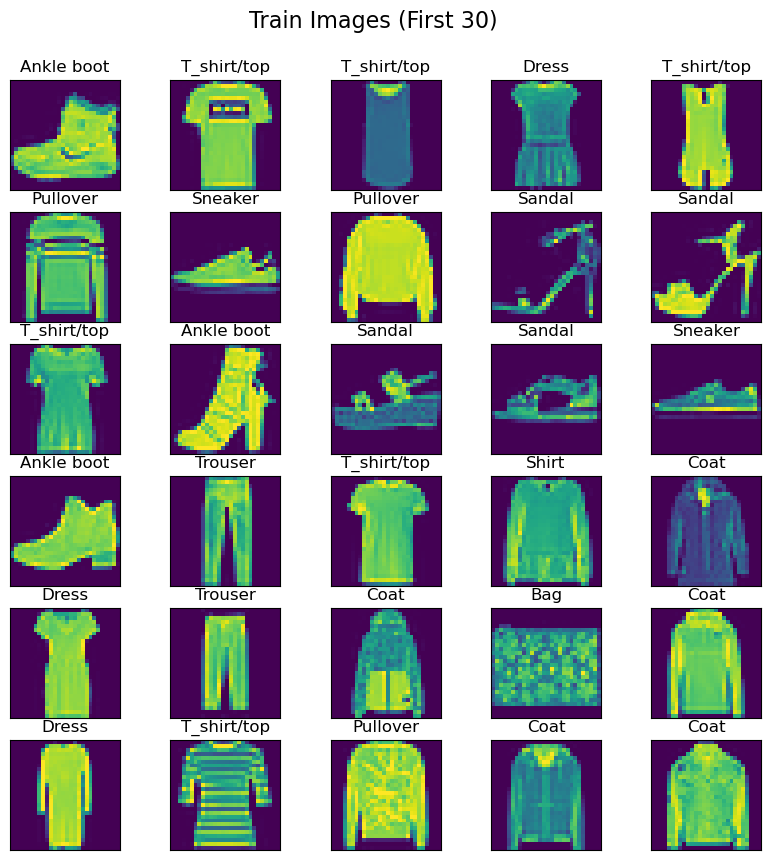

In [1]:
from data_loader import load_mnist, show_image
import os
current_dir = os.getcwd()
project_root = os.path.dirname(current_dir)
data_dir = os.path.join(project_root, 'data')
train_images, train_labels = load_mnist(data_dir, kind='train')
test_images, test_labels = load_mnist(data_dir, kind='t10k')
show_image(train_images, train_labels, test_images, test_labels)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import time
import logging
from pathlib import Path

torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Path("logs").mkdir(exist_ok=True)
Path("models").mkdir(exist_ok=True)

logging.basicConfig(
    filename='logs/training.log',
    level=logging.INFO,
    format='%(asctime)s - %(message)s'
)

In [2]:
from cnn_model import FashionCNN, print_model
model = FashionCNN().to(device)
print_model(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Param                Shape                Num #     
conv1.weight         (32, 1, 3, 3)        288       
conv1.bias           (32,)                32        
bn1.weight           (32,)                32        
bn1.bias             (32,)                32        
conv2.weight         (64, 32, 3, 3)       18432     
conv2.bias           (64,)                64        
bn2.weight           (64,)                64        
bn2.bias             (64,)                64        
fc1.weight           (512, 3136)          1605632   
fc1.bias             (512,)               512       
fc2.weight           (10, 512)            5120      
fc2.bias             (10,)                10        
Total params: 1630282


In [4]:
from train import train_model, preprocess_data
train_loader, test_loader = preprocess_data(train_images, train_labels, test_images, test_labels)
# 训练模型
start_time = time.time()
train_loss, train_acc, test_loss, test_acc = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs=20
)
print(f'Training completed in {time.time()-start_time:.2f} seconds')

Epoch [1/20] | Train Loss: 0.4571 Acc: 0.8349 | Test Loss: 0.3226 Acc: 0.8797
Epoch [2/20] | Train Loss: 0.3098 Acc: 0.8865 | Test Loss: 0.2981 Acc: 0.8907
Epoch [3/20] | Train Loss: 0.2692 Acc: 0.9019 | Test Loss: 0.2680 Acc: 0.9011
Epoch [4/20] | Train Loss: 0.2408 Acc: 0.9108 | Test Loss: 0.2396 Acc: 0.9083
Epoch [5/20] | Train Loss: 0.2190 Acc: 0.9196 | Test Loss: 0.2311 Acc: 0.9161
Epoch [6/20] | Train Loss: 0.1996 Acc: 0.9259 | Test Loss: 0.2424 Acc: 0.9136
Epoch [7/20] | Train Loss: 0.1847 Acc: 0.9314 | Test Loss: 0.2221 Acc: 0.9232
Epoch [8/20] | Train Loss: 0.1682 Acc: 0.9369 | Test Loss: 0.2097 Acc: 0.9252
Epoch [9/20] | Train Loss: 0.1558 Acc: 0.9409 | Test Loss: 0.2146 Acc: 0.9255
Epoch [10/20] | Train Loss: 0.1449 Acc: 0.9456 | Test Loss: 0.2167 Acc: 0.9258
Epoch [11/20] | Train Loss: 0.1350 Acc: 0.9489 | Test Loss: 0.2146 Acc: 0.9299
Epoch [12/20] | Train Loss: 0.1244 Acc: 0.9523 | Test Loss: 0.2325 Acc: 0.9248
Epoch [13/20] | Train Loss: 0.1142 Acc: 0.9567 | Test Loss: 0

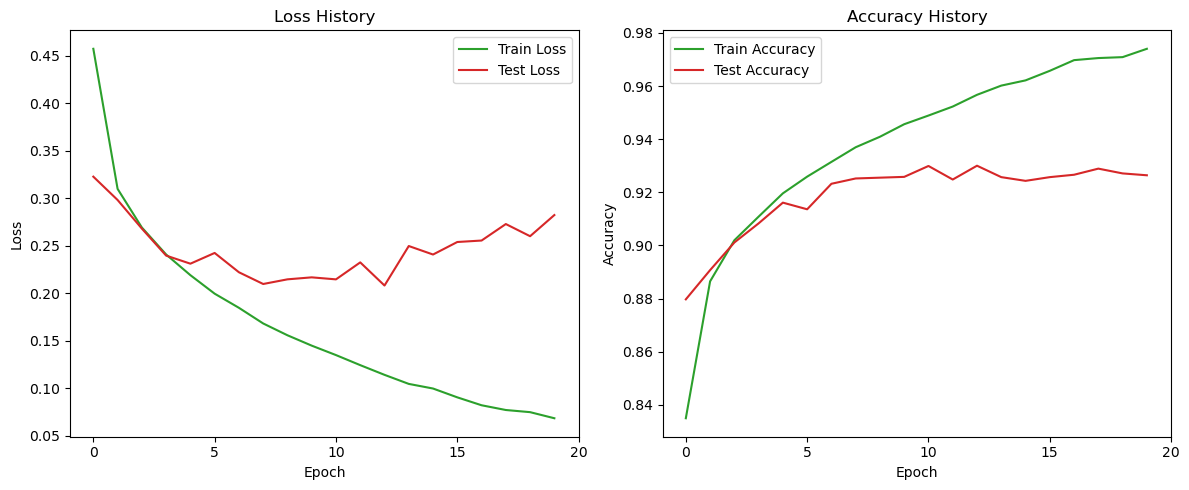

In [5]:
from plot import plot_confusion_matrix, visualize_history
visualize_history(train_loss, train_acc, test_loss, test_acc)

Best Model Test Accuracy: 0.9300


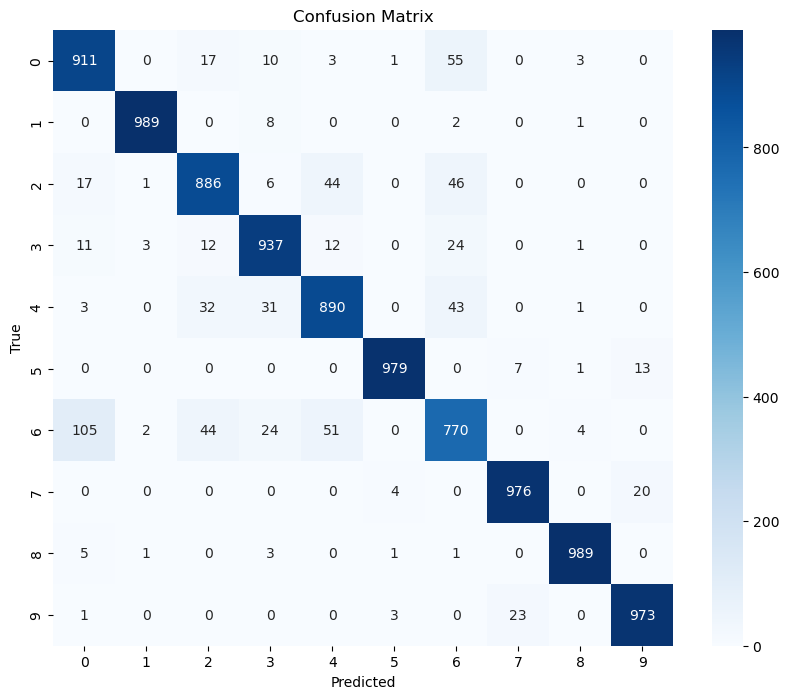

+-------+---------------+
| Epoch | Test Accuracy |
+-------+---------------+
|   1   |     0.8797    |
|   2   |     0.8907    |
|   3   |     0.9011    |
|   4   |     0.9083    |
|   5   |     0.9161    |
|   6   |     0.9136    |
|   7   |     0.9232    |
|   8   |     0.9252    |
|   9   |     0.9255    |
|   10  |     0.9258    |
|   11  |     0.9299    |
|   12  |     0.9248    |
|   13  |     0.9300    |
|   14  |     0.9257    |
|   15  |     0.9243    |
|   16  |     0.9257    |
|   17  |     0.9266    |
|   18  |     0.9289    |
|   19  |     0.9271    |
|   20  |     0.9264    |
+-------+---------------+


In [7]:
from predict import evaluate_model
# 加载最佳模型并绘制混淆矩阵
model.load_state_dict(torch.load('models/best_model.pth'))
final_loss, final_acc = evaluate_model(model, test_loader, criterion)
print(f'Best Model Test Accuracy: {final_acc:.4f}')
plot_confusion_matrix(model, test_loader)

# 验证所有保存模型的准确率
model_files = sorted(Path('models').glob('model_epoch_*.pth'))
results = []
for model_file in model_files:
    model.load_state_dict(torch.load(model_file))
    _, acc = evaluate_model(model, test_loader, criterion)
    epoch = int(model_file.stem.split('_')[-1])
    results.append((epoch, acc))
    
# 打印结果表格
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ["Epoch", "Test Accuracy"]
for epoch, acc in sorted(results):
    table.add_row([epoch, f"{acc:.4f}"])
print(table)